In [1]:
import data
import torch
import sde
import policy
import numpy as np
from torch.optim import SGD, RMSprop, Adagrad, AdamW, lr_scheduler, Adam
from torch.utils.tensorboard import SummaryWriter
from torch_ema import ExponentialMovingAverage
import matplotlib.pyplot as plt
import runner
from runner import Runner
import util



def build_optimizer_ema_sched(opt, policy):
    direction = policy.direction

    optim_name = {
        'Adam': Adam,
        'AdamW': AdamW,
        'Adagrad': Adagrad, 
        'RMSprop': RMSprop,
        'SGD': SGD,
    }.get(opt.optimizer)

    optim_dict = {
            "lr": opt.lr_f if direction=='forward' else opt.lr_b,
            'weight_decay':opt.l2_norm,
    }
    if opt.optimizer == 'SGD':
        optim_dict['momentum'] = 0.9

    optimizer = optim_name(policy.parameters(), **optim_dict)
    ema = ExponentialMovingAverage(policy.parameters(), decay=0.99)
    if opt.lr_gamma < 1.0:
        sched = lr_scheduler.StepLR(optimizer, step_size=opt.lr_step, gamma=opt.lr_gamma)
    else:
        sched = None

    return optimizer, ema, sched

class arg:
    samp_bs = 1000
    # problem_name = 'Scurve'
    problem_name = 'Scurve_condi'
    inner_itr = 2
    mask_update_itr = 1

    condition = True


    device = 'cuda:0'
    t0 = 0
    T=1
    interval=100
    sde_type = 've'
    noise_type = 'gaussian'
    sigma_min = 0.01
    sigma_max = 0.3
    forward_net = 'toy'
    backward_net = 'toy'
    hidden_nodes = 128
    blocks = 1
    optimizer = 'AdamW'
    lr = 4e-3
    lr_f = 4e-3
    lr_b = 4e-3
    lr_gamma = 0.8
    lr_step = 500
    l2_norm = 1e-3
    train_method = 'joint'
    seed = 123
    num_itr = 1000
    eval_itr = 100
    

    

opt = arg()
opt.device
opt.data_dim = [2]


     Likelihood-Training of Schrodinger Bridge
setting configurations...


In [2]:
with torch.cuda.device(opt.device):
    run = Runner(opt)

    run.sb_joint_train(opt)

build boundary distribution...
build base sde...
build forward policy...
number of parameters is 141442
build backward policy...
number of parameters is 141442
[SB joint] train_it 1/1000 | lr:4.00e-03 | loss:2.9942 | time:0:00:02.98
[SB joint] train_it 2/1000 | lr:4.00e-03 | loss:3.1318 | time:0:00:03.50
[SB joint] train_it 3/1000 | lr:4.00e-03 | loss:2.9826 | time:0:00:04.02
[SB joint] train_it 4/1000 | lr:4.00e-03 | loss:2.8830 | time:0:00:04.53
[SB joint] train_it 5/1000 | lr:4.00e-03 | loss:2.8172 | time:0:00:05.05
[SB joint] train_it 6/1000 | lr:4.00e-03 | loss:2.8475 | time:0:00:05.57
[SB joint] train_it 7/1000 | lr:4.00e-03 | loss:2.8561 | time:0:00:06.08
[SB joint] train_it 8/1000 | lr:4.00e-03 | loss:2.7974 | time:0:00:06.60
[SB joint] train_it 9/1000 | lr:4.00e-03 | loss:2.7525 | time:0:00:07.12
[SB joint] train_it 10/1000 | lr:4.00e-03 | loss:2.7434 | time:0:00:07.68
[SB joint] train_it 11/1000 | lr:4.00e-03 | loss:2.7388 | time:0:00:08.19
[SB joint] train_it 12/1000 | lr:4.

KeyboardInterrupt: 

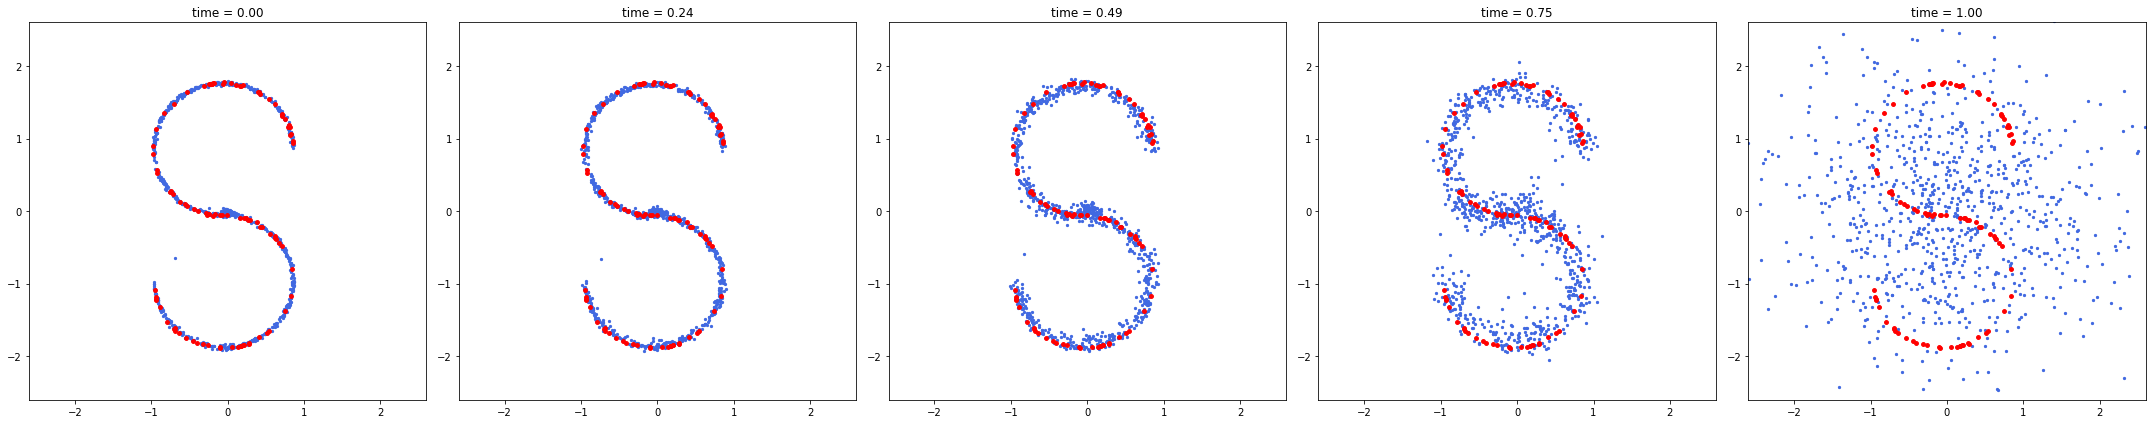

In [3]:
with torch.no_grad():
    ts      = run.ts
    policy_b = run.z_b
    xs_b, _, _ =run.dyn.sample_traj(ts, policy_b, save_traj=True)
direction='backward'
traj = xs_b
n_snapshot = 5
lims = [-2.6, 2.6]

total_steps = traj.shape[1]
sample_steps = np.linspace(0, total_steps-1, n_snapshot).astype(int)
fig, axs = plt.subplots(1, n_snapshot)
fig.set_size_inches(n_snapshot*6, 6)
color = 'salmon' if direction=='forward' else 'royalblue'


idx_target = run.dyn.idx_target
idx_condi = run.dyn.idx_condi

tarj_condi =  run.p.x_obs[idx_condi]


for ax, step in zip(axs, sample_steps):

    ax.scatter(traj[idx_target,step,0],traj[idx_target,step,1], s=5, color=color)
    # ax.scatter(traj[idx_condi,step,0],traj[idx_condi,step,1], s=5, color='black')
    

    ax.scatter(tarj_condi[:,0],tarj_condi[:,1], s=15, color='red')

    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
    ax.set_title('time = {:.2f}'.format(step/(total_steps-1)*opt.T))
fig.tight_layout()

In [5]:
def set_valid_condi(dyn,p):
    idx_condi = np.concatenate([np.arange(0,100),np.arange(450,550),np.arange(900,1000)])
    idx_target =  np.concatenate([np.arange(100,450),np.arange(550,900)])
    mask_condi = np.zeros_like(p.x_obs)
    mask_condi[idx_condi,:]=1
    mask_target = 1-mask_condi

    x_target = np.multiply(p.x_obs,1-mask_condi)
    x_condi = np.multiply(p.x_obs,mask_condi)

    dyn.x_condi = torch.Tensor(x_condi).to(opt.device)
    dyn.mask_target = torch.Tensor(mask_target).to(opt.device)
    dyn.idx_target = idx_target
    dyn.idx_condi = idx_condi

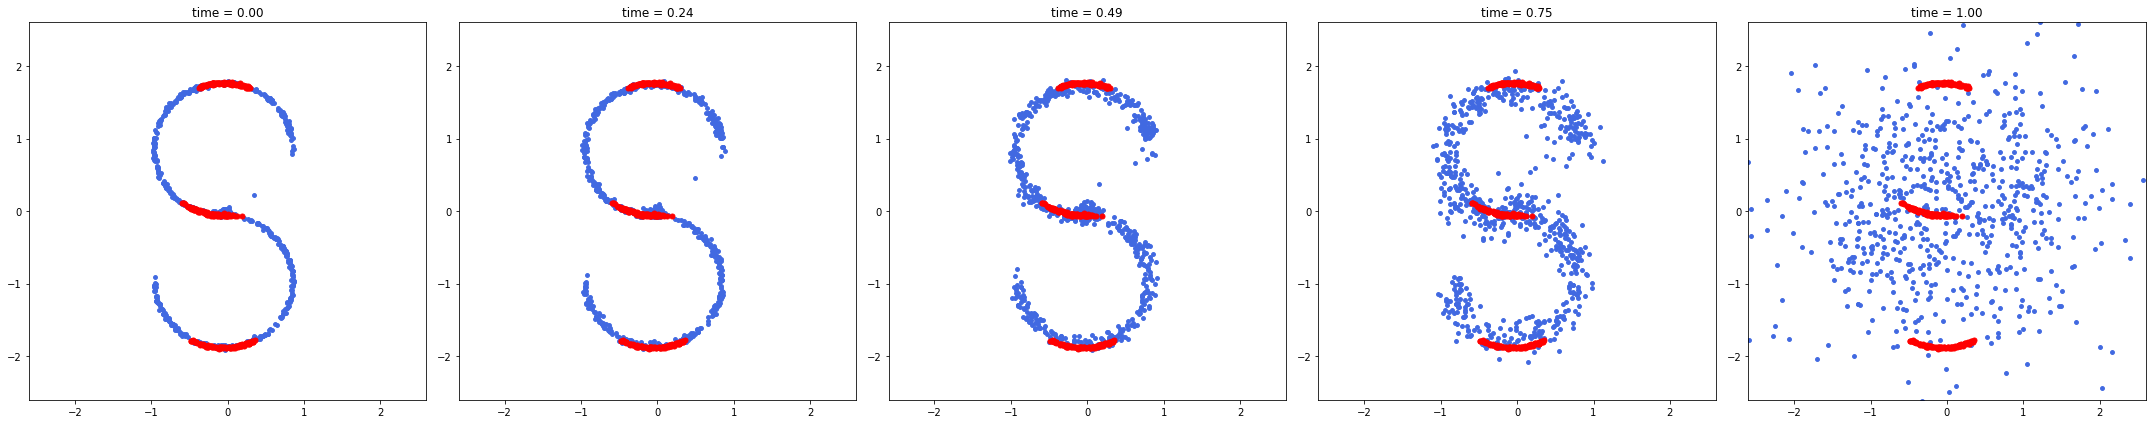

In [6]:



with torch.no_grad():
    ts      = run.ts
    policy_b = run.z_b

    set_valid_condi(run.dyn,run.p)
    
    policy_b.net.set_x_condi(run.dyn.x_condi.repeat(opt.interval,1))

    xs_b, _, _ =run.dyn.sample_traj(ts, policy_b, save_traj=True)

direction='backward'
traj = xs_b
n_snapshot = 5
lims = [-2.6, 2.6]

total_steps = traj.shape[1]
sample_steps = np.linspace(0, total_steps-1, n_snapshot).astype(int)
fig, axs = plt.subplots(1, n_snapshot)
fig.set_size_inches(n_snapshot*6, 6)
color = 'salmon' if direction=='forward' else 'royalblue'


idx_target = run.dyn.idx_target
idx_condi = run.dyn.idx_condi

tarj_condi =  run.p.x_obs[idx_condi]


for ax, step in zip(axs, sample_steps):

    ax.scatter(traj[idx_target,step,0],traj[idx_target,step,1], s=15, color=color)
    # ax.scatter(traj[idx_condi,step,0],traj[idx_condi,step,1], s=5, color='black')
    

    ax.scatter(tarj_condi[:,0],tarj_condi[:,1], s=25, color='red')

    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
    ax.set_title('time = {:.2f}'.format(step/(total_steps-1)*opt.T))
fig.tight_layout()

In [23]:
traj.shape

torch.Size([1000, 100, 2])

In [3]:
# bug-free run with condition case
with torch.cuda.device(opt.device):
    run = Runner(opt)

    policy_f, policy_b = run.z_f, run.z_b
    policy_f = runner.activate_policy(policy_f)
    policy_b = runner.activate_policy(policy_b)
    optimizer_f, _, sched_f = run.get_optimizer_ema_sched(policy_f)
    optimizer_b, _, sched_b = run.get_optimizer_ema_sched(policy_b)

    ts      = run.ts
    batch_x = opt.samp_bs

    optimizer_f.zero_grad()
    optimizer_b.zero_grad()

    xs_f, zs_f, x_term_f = run.dyn.sample_traj(ts, policy_f, save_traj=True)

    # the x_condi is set for forward-z nn during the sample
    # we set it for backward-b nn
    
    if opt.condition:
        policy_b.net.set_x_condi(run.dyn.x_condi.repeat(opt.interval,1))

    # xs_f = util.flatten_dim01(xs_f).to(opt.device)
    # zs_f = util.flatten_dim01(zs_f).to(opt.device)
    # x_term_f = x_term_f.to(opt.device)
    # _ts = ts.repeat(batch_x)

    # loss = runner.compute_sb_nll_joint_train(
    #             opt, batch_x, run.dyn, _ts, xs_f, zs_f, x_term_f, policy_b
    #         )

    # assert opt.train_method == 'joint'
    # assert policy_b.direction == 'backward'
    # assert xs_f.requires_grad and zs_f.requires_grad and x_term_f.requires_grad
    # div_gz_b, zs_b = runner.compute_div_gz(opt, run.dyn, _ts, xs_f, policy_b, return_zs=True)
    # loss = 0.5*(zs_f + zs_b)**2 + div_gz_b
    # loss = torch.sum(loss*run.dyn.dt) / batch_x
    # loss = loss - run.dyn.q.log_prob(x_term_f).mean()

    # loss.backward()

build boundary distribution...
build base sde...
build forward policy...
number of parameters is 141442
build backward policy...
number of parameters is 141442


In [9]:
print(xs_f.shape)
print(run.dyn.mask_target.shape)

torch.Size([1000, 100, 2])
torch.Size([1000, 2])


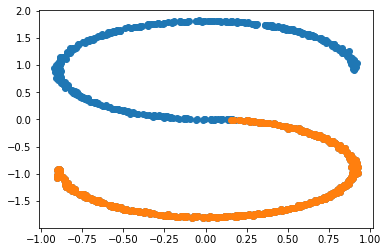

In [6]:
data = run.p.x_obs

plt.scatter(data[:,0],data[:,1])
plt.scatter(data[:500,0],data[:500,1])

In [24]:
a = np.zeros_like(sort_x)
a[[1,2,3],:] =1
a


array([[0., 0.],
       [1., 1.],
       [1., 1.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [2]:
z_b.net

ToyPolicy(
  (t_module): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (x_module): ResNet_FC(
    (map): Linear(in_features=2, out_features=128, bias=True)
    (res_blocks): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): SiLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): SiLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): SiLU()
      )
    )
  )
  (out_module): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [21]:
print(q.sample().shape) # q (normal) is sampler class
print(p.samples.shape) # p (normal) is a given dataset


torch.Size([1000, 2])
(1000, 2)


In [14]:
class A:
    def __init__(self):
        self.v=1.0
class B:
    def __init__(self,a):
        self.my_a=a

A_obj = A()
B_obj1 = B(A_obj)
B_obj2 = B(A_obj)

B_obj1.my_a.v=2
print(B_obj2.my_a.v, A_obj.v)


2 2


In [18]:
if hasattr(A_obj, 'ds'):
    print(A_obj.v)